In [ ]:
# load the fine-tuning data

import json
file_path= "../output/fine_tuning/data/fine_tuning.json"
with open(file_path,"r") as file:
    data=json.load(file)

In [ ]:
# load   the tokenizer
import sys
sys.path.append("..")

In [ ]:
from minbpe import RegexTokenizer

tokenizer=RegexTokenizer()
tokenizer.load(model_file="../output/tokenizer/darija_tokenizer.model")

def get_vocab_size(tokenizer:RegexTokenizer)->int:
    vocab=tokenizer.vocab
    special_tokens=tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

In [ ]:
# tokenize the sequence

tokenized_data=[]
for item in data:
    tokenized_item=tokenizer.encode(item,allowed_special="all")
    tokenized_data.append(tokenized_item)

len(tokenized_data[0])

In [ ]:
# spliting data

initial_split_index = int(0.95 * len(data))

# Adjusting the index to ensure that the training set ends with "Assistant" message
# and that the validation set starts with "You" message

# Scanning backward to find an Assistant message
split_index = initial_split_index
while split_index > 0 and not data[split_index-1].startswith('<|startoftext|>Assistant'):
    split_index -= 1

train_data = data[:split_index]
val_data = data[split_index:]

print("Training set: ")
print(f"Start message: {train_data[0].split('<|separator|>')[0]}")
print(f"End message: {train_data[-1].split('<|separator|>')[0]}")

print("\nValidation set: ")
print(f"Start message: {val_data[0].split('<|separator|>')[0]}")
print(f"End message: {val_data[-1].split('<|separator|>')[0]}")

In [ ]:
# split tokenized data

In [ ]:
train_data = tokenized_data[:split_index]
val_data = tokenized_data[split_index:]

In [ ]:
block_size = 256


def combine_turns(data: list[list[int]], should_trim_long_sequences: bool) -> list[list[int]]:
    combined_turns_data = []
    for i in range(0, len(data)-1, 2):
        you_message = data[i]
        assistant_message = data[i+1]
        if not you_message or not assistant_message:
            continue

        final_message = you_message + assistant_message
        if len(final_message) > block_size and should_trim_long_sequences:
            final_message = final_message[-block_size:]

        combined_turns_data.append(final_message)
    return combined_turns_data


combined_train_data = combine_turns(
    data=train_data,
    should_trim_long_sequences=True
)
combined_val_data = combine_turns(
    data=val_data,
    should_trim_long_sequences=True
)

In [ ]:
print("Train data")
print(f"Length before: {len(train_data)}")
print(f"Length after: {len(combined_train_data)}")

print("\nValidation data")
print(f"Length before: {len(val_data)}")
print(f"Length after: {len(combined_val_data)}")

In [ ]:
import torch
torch.manual_seed(3647)

# The token `<|padding|>` is used to mask the padding tokens.
# Masking means the model will ignore these tokens during training.
# In other words, the loss will not be calculated for these tokens.
padding_token = tokenizer.special_tokens["<|padding|>"]


def apply_padding_to_data(data: list[list[int]], block_size: int, padding_token: int) -> torch.Tensor:
    tensors = []
    for i in range(len(data)):
        tensor = torch.tensor(data[i])
        padded_tensor = torch.nn.functional.pad(
            input=tensor,
            # for right padding:
            pad=(0, block_size - len(tensor)),
            # pad=(block_size - len(tensor), 0),
            value=padding_token
        )
        tensors.append(padded_tensor)

    return torch.stack(tensors)


train_data_tensor = apply_padding_to_data(
    data=combined_train_data,
    block_size=block_size,
    padding_token=padding_token
)
val_data_tensor = apply_padding_to_data(
    data=combined_val_data,
    block_size=block_size,
    padding_token=padding_token
)

train_data_tensor.shape, val_data_tensor.shape

create data loaders

In [ ]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data  # shape: (num_samples, block_size)
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        return x, y


batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FineTuningDataset(
    data=train_data_tensor,
    device=device,
    padding_token=padding_token
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = FineTuningDataset(
    data=val_data_tensor,
    device=device,
    padding_token=padding_token
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
x, y = next(iter(train_loader))
x.shape, y.shape

# Fine-tuning with LoRA

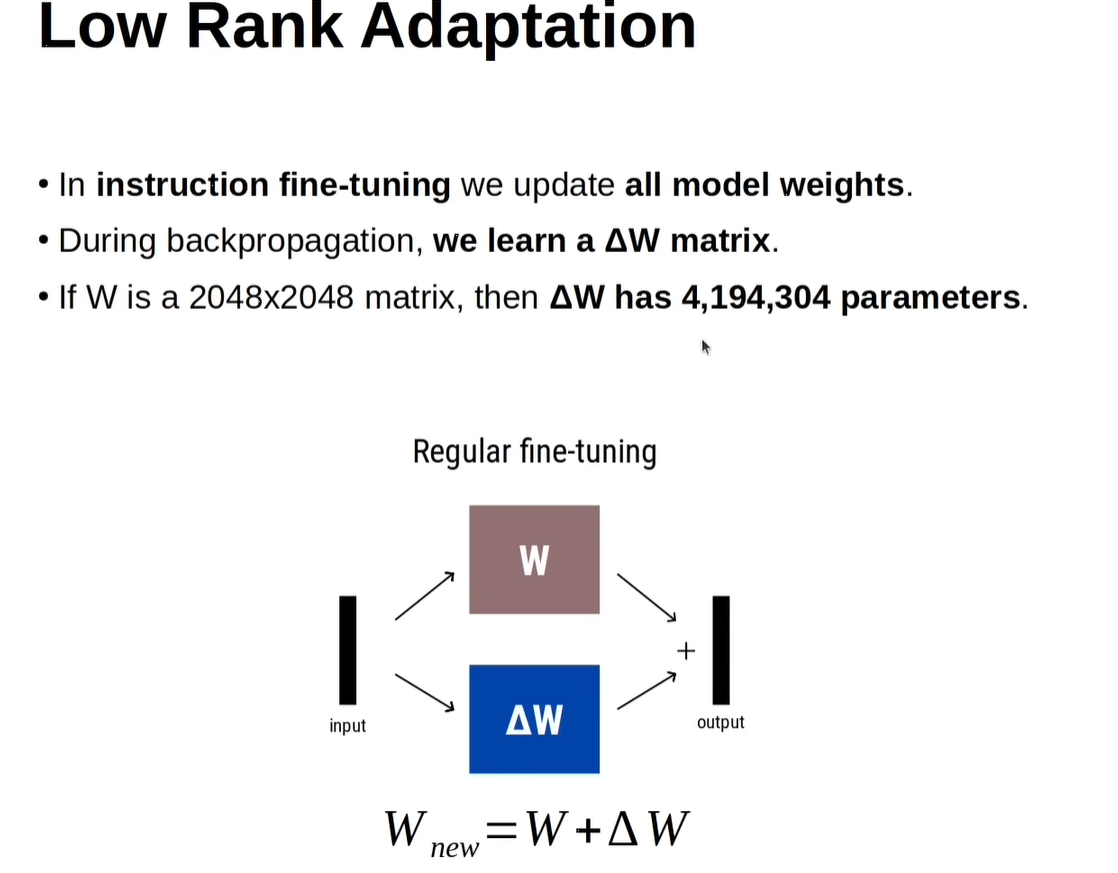

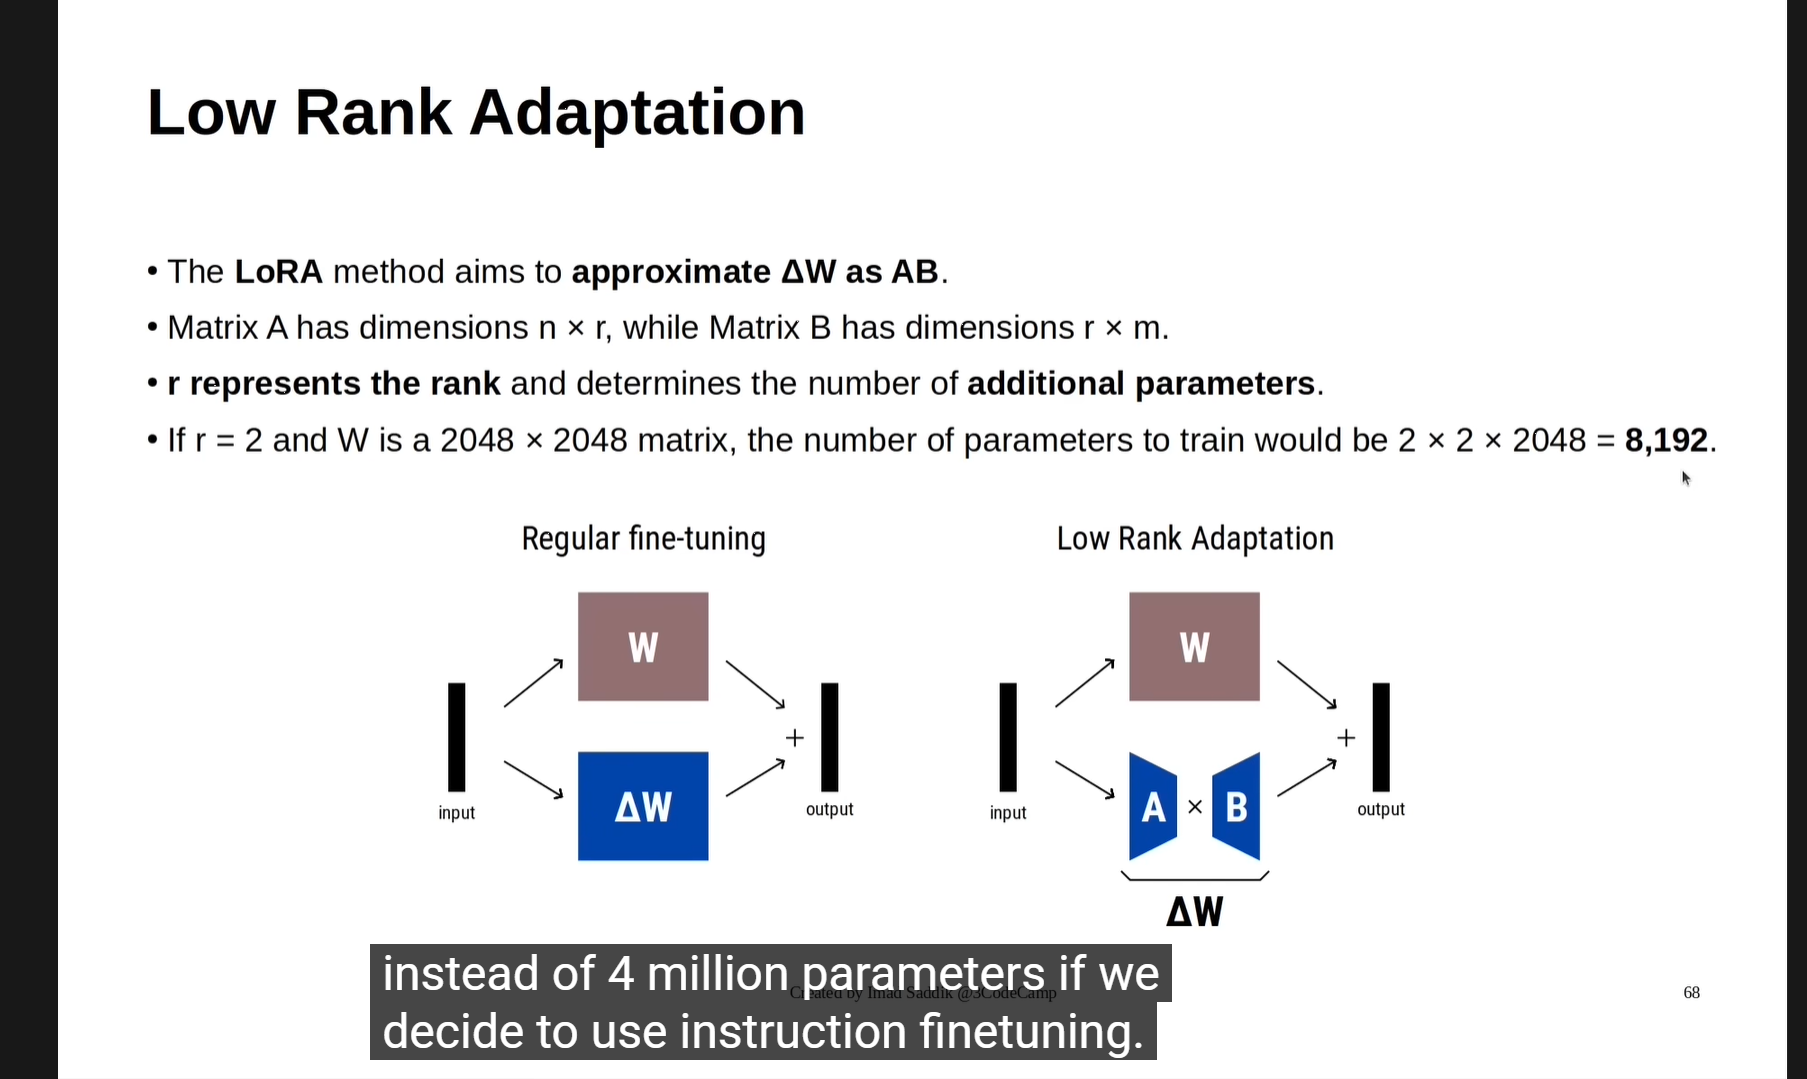

In [ ]:
# load the saved checkpoints

from transformer.model import GPTLanguageModel

block_size = 256
n_embd = 512
n_head = 8
n_layer = 4
dropout = 0.2
batch_size = 64
vocab_size = get_vocab_size(tokenizer)

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)
model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')


In [ ]:
checkpoint_path = "../output/pre_training/base_model_checkpoint.pth"
checkpoint = torch.load(
    checkpoint_path, weights_only=True, map_location=device)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

### 2. Add LoRA layers

In [ ]:
from transformer.lora import get_lora_model, print_trainable_parameters

lora_model=get_lora_model(
    model=model,
    lora_config={
        "rank":4,
        "alpha":8,
    },
    device=device,
)
print_trainable_parameters(lora_model)

````markdown
### LoRA Model Setup and Trainable Parameters

This code snippet demonstrates how to apply Low-Rank Adaptation (LoRA) to a pre-trained transformer model using functions from the `transformer.lora` module.

#### Code Breakdown

1. **Importing Functions**
   ```python
   from transformer.lora import get_lora_model, print_trainable_parameters
````

* `get_lora_model`: Wraps a given model with LoRA adapters to reduce the number of trainable parameters.
* `print_trainable_parameters`: Prints the number of trainable parameters versus total parameters for transparency and debugging.

2. **Applying LoRA**

   ```python
   lora_model = get_lora_model(
       model=model,
       lora_config={
           "rank": 4,
           "alpha": 8,
       },
       device=device,
   )
   ```

   * `model`: The base transformer model to be adapted.
   * `lora_config`:

     * `"rank"`: Specifies the rank of the low-rank matrices (the bottleneck dimension). Lower values mean fewer parameters.
     * `"alpha"`: Scaling factor for the LoRA layers, which helps in balancing the adaptation.
   * `device`: Specifies the device (CPU or GPU) where the model will be moved after applying LoRA.

3. **Displaying Trainable Parameters**

   ```python
   print_trainable_parameters(lora_model)
   ```

   * This outputs a summary of how many parameters are actually trainable (after applying LoRA) compared to the full model. It helps verify that only LoRA-specific layers are being trained.

#### Purpose

Using LoRA allows for fine-tuning large models efficiently by only updating a small subset of parameters, significantly reducing memory usage and computational cost.

```
```


Generate from the model to make sure that the weights were loaded correctly.

In [ ]:
input_tokens=tokenizer.encode("Salam labas",allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

````markdown
### Text Generation with a Pretrained Model

This code performs text generation using a pretrained model and tokenizer. It encodes an input string, feeds it into the model, generates a continuation of the text, and decodes the output back to human-readable format.

---

#### 1. **Tokenizing Input Text**
```python
input_tokens = tokenizer.encode("Salam labas", allowed_special="all")
````

* **`tokenizer.encode(...)`**: Converts the input string `"Salam labas"` into a list of token IDs that the model understands.
* **`allowed_special="all"`**: Ensures that special tokens (like `<bos>`, `<eos>`, etc.) are preserved during encoding if present in the tokenizer vocabulary.

---

#### 2. **Converting Tokens to Tensor**

```python
input_tokens = torch.tensor(input_tokens, dtype=torch.long).unsqueeze(0).to(device)
```

* **`torch.tensor(...)`**: Converts the list of token IDs into a PyTorch tensor, which is the required input format for the model.
* **`dtype=torch.long`**: Specifies the data type needed for token IDs.
* **`unsqueeze(0)`**: Adds a batch dimension, making the shape `[1, sequence_length]`, as models expect batched input.
* **`.to(device)`**: Moves the tensor to the same device as the model (CPU or GPU).

---

#### 3. **Setting Model to Evaluation Mode**

```python
model.eval()
```

* Switches the model to **evaluation mode**. This disables features like dropout or batch norm, which are only active during training.

---

#### 4. **Generating Text Without Gradient Tracking**

```python
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)
```

* **`torch.no_grad()`**: Disables gradient computation to save memory and computation during inference.
* **`model.generate(...)`**: Autoregressively generates new tokens from the input prompt.

  * **`input_tokens=input_tokens`**: Initial context for generation.
  * **`max_new_tokens=100`**: Specifies how many new tokens the model should generate beyond the input.

---

#### 5. **Decoding the Generated Output**

```python
print(tokenizer.decode(output[0].tolist()))
```

* **`output[0]`**: Since the model output includes a batch dimension, this selects the first (and only) sequence.
* **`.tolist()`**: Converts the tensor of token IDs back into a regular Python list.
* **`tokenizer.decode(...)`**: Converts the token IDs back into a human-readable string.
* The final result is the original input followed by the model’s continuation, printed to the console.

---

### Summary

This sequence of operations allows you to input a prompt ("Salam labas"), tokenize it, feed it into a model for generation, and then decode and display the generated text. It's a typical inference pipeline for language generation using models like GPT or similar transformer architectures.

```
```


In [ ]:
input_tokens = tokenizer.encode("Salam labas ", allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

lora_model.eval()
with torch.no_grad():
    output = lora_model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

````markdown
### Text Generation Using a LoRA-Adapted Model

This code demonstrates how to perform text generation using a transformer model that has been fine-tuned with LoRA (Low-Rank Adaptation). The process involves tokenizing input text, generating new tokens with the LoRA model, and decoding the output into readable text.

---

#### 1. **Encoding the Input Text**
```python
input_tokens = tokenizer.encode("Salam labas ", allowed_special="all")
````

* Converts the input string `"Salam labas "` into a sequence of token IDs.
* `allowed_special="all"` ensures that all special tokens are recognized and preserved during tokenization.

---

#### 2. **Preparing the Input for the Model**

```python
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)
```

* Converts the list of token IDs into a PyTorch tensor.
* `unsqueeze(0)` adds a batch dimension so the input has shape `[1, sequence_length]`, as required by the model.
* `.to(device)` moves the input tensor to the appropriate device (CPU or GPU) where the model resides.

---

#### 3. **Switching the Model to Evaluation Mode**

```python
lora_model.eval()
```

* Puts the LoRA-adapted model into evaluation mode, disabling training-specific operations like dropout to ensure deterministic results during inference.

---

#### 4. **Generating Tokens Without Gradient Tracking**

```python
with torch.no_grad():
    output = lora_model.generate(input_tokens=input_tokens, max_new_tokens=100)
```

* `torch.no_grad()` disables gradient calculations, reducing memory usage and improving performance during inference.
* `lora_model.generate(...)` uses the model to generate new tokens:

  * `input_tokens`: The prompt that guides the generation.
  * `max_new_tokens=100`: The maximum number of new tokens the model is allowed to generate beyond the initial input.

---

#### 5. **Decoding and Printing the Output**

```python
print(tokenizer.decode(output[0].tolist()))
```

* `output[0]` selects the first (and only) output sequence from the batch.
* `.tolist()` converts the output tensor into a list of token IDs.
* `tokenizer.decode(...)` translates the list of token IDs back into a human-readable string, including the generated continuation.
* The result is printed to the console.

---

### Summary

This pipeline performs text generation using a LoRA-tuned model. It is especially useful in scenarios where you want to efficiently fine-tune and use large language models with fewer trainable parameters. The code illustrates how to tokenize a prompt, generate a continuation using the adapted model, and decode the result for display.

```
```


### 3. Estimate Loss

In [ ]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = []
        for x, y in loader:
            with torch.no_grad():
                _, loss = model(x, y)
            losses.append(loss.item())
        output[split] = sum(losses) / len(losses)

    model.train()
    return output

````markdown
### Loss Estimation Function for Training and Validation

This function, `estimate_loss`, evaluates the average loss of a given model on both the training and validation datasets. It is designed to be used during training to monitor model performance on unseen data.

---

#### Function Signature
```python
@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Dict[str, float]:
````

* **`@torch.no_grad()`**: Disables gradient calculation to improve performance and reduce memory usage during evaluation.
* **`model`**: A PyTorch model that returns a tuple `(logits, loss)` when called with inputs and targets.
* **`train_loader`, `val_loader`**: Data loaders that yield batches of `(x, y)` pairs for training and validation respectively.
* **Returns**: A dictionary with the average loss for each split (`"train"` and `"val"`).

---

#### Function Logic

1. **Initialize Output Dictionary**

   ```python
   output = {}
   model.eval()
   ```

   * Sets the model to evaluation mode using `.eval()` to deactivate behaviors like dropout.

2. **Loop Over Splits**

   ```python
   for split, loader in [('train', train_loader), ('val', val_loader)]:
   ```

   * Iterates through both training and validation sets.

3. **Loop Over Batches**

   ```python
   for x, y in loader:
       with torch.no_grad():
           _, loss = model(x, y)
       losses.append(loss.item())
   ```

   * Iterates over batches in the current data loader.
   * Passes input `x` and target `y` to the model.
   * The model returns a tuple: `(logits, loss)`. The loss is extracted and converted to a scalar using `.item()`.
   * Each loss is appended to a list for averaging.

4. **Compute Average Loss**

   ```python
   output[split] = sum(losses) / len(losses)
   ```

   * Calculates the mean loss for the current split and stores it in the output dictionary.

5. **Reset Model to Training Mode**

   ```python
   model.train()
   ```

   * Switches the model back to training mode after evaluation.

6. **Return Results**

   ```python
   return output
   ```

   * Returns a dictionary like: `{'train': 0.34, 'val': 0.42}` representing average losses.

---

### Summary

The `estimate_loss` function provides a clean way to track model performance by calculating the average training and validation loss over an epoch. It ensures no gradients are computed and switches the model into evaluation and back to training mode as needed.

```
```


### 4. Save Checkpoints

In [ ]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

````markdown
### Saving Model Checkpoints

The `save_checkpoint` function is used to save the training state of a model at a specific point during training. This includes the model weights, optimizer state, current epoch, and loss value. Saving checkpoints allows you to resume training later or analyze intermediate training stages.

---

#### Function Definition
```python
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
````

* **`model`**: The instance of the `GPTLanguageModel` whose parameters will be saved.
* **`optimizer`**: The optimizer used during training (e.g., Adam, SGD), whose state is saved to allow training to resume with the same momentum and learning rate schedules.
* **`epoch`**: The current epoch number, useful for resuming training.
* **`loss`**: The current loss value at the time of saving, helpful for logging or comparison.
* **`file_path`**: Destination path for the saved checkpoint file. Defaults to `"checkpoint.pth"`.

---

#### Checkpoint Creation

```python
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss
}
```

* **`model_state_dict`**: A dictionary containing all model parameters (weights and biases).
* **`optimizer_state_dict`**: Contains internal state of the optimizer (e.g., learning rates, momentum).
* These are packaged along with the current epoch and loss into a single dictionary.

---

#### Saving the Checkpoint

```python
torch.save(checkpoint, file_path)
```

* Uses PyTorch’s `torch.save` function to serialize the checkpoint dictionary to disk.
* The file can later be loaded using `torch.load()` and restored using `.load_state_dict()` on the model and optimizer.

---

### Summary

The `save_checkpoint` function is essential for long-running training processes. It enables recovery from interruptions and facilitates model evaluation at different training stages by storing the necessary training state information.

```
```


### 5. Training Loop

In [ ]:
max_iters = 10
eval_interval = 10
learning_rate = 1e-4

optimizer = torch.optim.AdamW(lora_model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=lora_model,
                train_loader=train_loader,
                val_loader=val_loader,
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(
                f"iteration {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )

        # Training step
        logits, loss = lora_model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    save_checkpoint(
        model=lora_model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path=f"../output/fine_tuning/adapters/run_1/checkpoint_{iteration}.pth"
    )


### LoRA Model Fine-Tuning Loop with Checkpointing and Evaluation

This training loop performs fine-tuning of a transformer model enhanced with LoRA (Low-Rank Adaptation). It includes periodic evaluation, loss tracking, and checkpoint saving after each epoch.

---

#### 1. **Training Configuration**
```python
max_iters = 10
eval_interval = 10
learning_rate = 1e-4
```

* **`max_iters`**: Total number of training epochs.
* **`eval_interval`**: Frequency (in steps) at which to evaluate the model on training and validation data.
* **`learning_rate`**: Learning rate for the optimizer.

---

#### 2. **Optimizer and Loss Storage Initialization**

```python
optimizer = torch.optim.AdamW(lora_model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
```

* **`AdamW`**: Optimizer that decouples weight decay from gradient updates, suitable for transformer models.
* **`train_losses` / `val_losses`**: Lists to store the average loss per evaluation step for training and validation data.

---

#### 3. **Main Training Loop**

```python
for iteration in range(max_iters):
```

* Outer loop iterates over epochs.

```python
for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
```

* Inner loop iterates over mini-batches from the training data.

---

#### 4. **Model Evaluation**

```python
if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
```

* Evaluation is triggered every `eval_interval` steps or at the last batch of the epoch.

```python
losses = estimate_loss(...)
train_losses.append(losses['train'])
val_losses.append(losses['val'])
```

* Calls `estimate_loss()` to compute average losses for both training and validation.
* Appends these values to respective lists for later visualization or logging.

```python
print(...)
```

* Logs the current step and corresponding losses for monitoring training progress.

---

#### 5. **Training Step**

```python
logits, loss = lora_model(x_batch, y_batch)
optimizer.zero_grad(set_to_none=True)
loss.backward()
optimizer.step()
```

* Forward pass: The model computes predictions and loss.
* **`zero_grad(set_to_none=True)`**: Clears old gradients efficiently.
* **`loss.backward()`**: Backpropagates gradients.
* **`optimizer.step()`**: Updates model parameters.

---

#### 6. **Checkpoint Saving**

```python
save_checkpoint(
    model=lora_model,
    optimizer=optimizer,
    epoch=iteration,
    loss=loss.item(),
    file_path=f"../output/fine_tuning/adapters/run_1/checkpoint_{iteration}.pth"
)
```

* Saves the current training state, including:

  * Epoch number
  * Model parameters
  * Optimizer state
  * Loss value
* Checkpoints are saved to uniquely named files for each epoch, enabling recovery and analysis at any point.

---

### Summary

This training loop efficiently fine-tunes a LoRA-adapted transformer model. It includes evaluation at regular intervals, tracks loss progression, and saves checkpoints after each epoch to support recovery or further training.

```
```


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [ ]:
def get_input_tokens(message: str) -> torch.Tensor:
    input_tokens = tokenizer.encode(
        f"<|startoftext|>{message}<|separator|>", allowed_special="all")
    input_tokens = torch.tensor(
        input_tokens, dtype=torch.long).unsqueeze(0).to(device)
    return input_tokens


user_message = "Salam labas fin ghadi?"
input_tokens = get_input_tokens(message=user_message)
model_answer = ""

lora_model.eval()
while True:
    output_tokens = lora_model.generate(
        input_tokens=input_tokens, max_new_tokens=1)
    last_generated_token = output_tokens[0, -1].item()
    if last_generated_token == tokenizer.special_tokens["<|endoftext|>"]:
        break

    input_tokens = torch.cat((input_tokens, output_tokens[:, -1:]), dim=1)
    model_answer += tokenizer.decode([last_generated_token])

    if len(output_tokens[0]) > block_size:
        input_tokens = input_tokens[:, -block_size:]

print(f"You: {user_message}")
print(f"Assistant: {model_answer}")


### Interactive Text Generation Loop with Token-Level Decoding

This script simulates an interactive dialogue using a LoRA-fine-tuned language model. It takes a user message, tokenizes it with special formatting, and generates a response **one token at a time**, stopping when an end-of-text token is encountered. The output is printed as a back-and-forth chat.

---

#### 1. **Function: `get_input_tokens`**
```python
def get_input_tokens(message: str) -> torch.Tensor:
    input_tokens = tokenizer.encode(
        f"<|startoftext|>{message}<|separator|>", allowed_special="all")
    input_tokens = torch.tensor(
        input_tokens, dtype=torch.long).unsqueeze(0).to(device)
    return input_tokens
```

* Adds special tokens to structure the input for the model:

  * `<|startoftext|>`: Marks the beginning of the conversation.
  * `<|separator|>`: Marks the end of the user’s message, prompting the model to start generating a response.
* Tokenizes the formatted string into input IDs.
* Converts the token list to a tensor, adds a batch dimension, and moves it to the correct device (CPU or GPU).

---

#### 2. **Setting Up the Dialogue**

```python
user_message = "Salam labas fin ghadi?"
input_tokens = get_input_tokens(message=user_message)
model_answer = ""
```

* The user's prompt is passed to the tokenizer function.
* An empty string `model_answer` is initialized to collect the model's response.

---

#### 3. **Model Evaluation Mode**

```python
lora_model.eval()
```

* Disables training-specific behaviors like dropout to ensure consistent inference.

---

#### 4. **Token-by-Token Generation Loop**

```python
while True:
    output_tokens = lora_model.generate(input_tokens=input_tokens, max_new_tokens=1)
    last_generated_token = output_tokens[0, -1].item()
```

* Generates **1 token at a time** using the current `input_tokens` as context.
* Extracts the last generated token ID for processing.

```python
if last_generated_token == tokenizer.special_tokens["<|endoftext|>"]:
    break
```

* Stops the loop when the model outputs an `<|endoftext|>` token, signaling the end of its response.

```python
input_tokens = torch.cat((input_tokens, output_tokens[:, -1:]), dim=1)
model_answer += tokenizer.decode([last_generated_token])
```

* Appends the newly generated token to the input to maintain context.
* Decodes and adds the new token to the growing `model_answer` string.

```python
if len(output_tokens[0]) > block_size:
    input_tokens = input_tokens[:, -block_size:]
```

* Ensures the context window (sequence length) doesn't exceed the model's maximum input size (`block_size`), by truncating the beginning of the sequence if needed.

---

#### 5. **Output the Conversation**

```python
print(f"You: {user_message}")
print(f"Assistant: {model_answer}")
```

* Displays the original user message and the assistant’s generated reply.

---

### Summary

This code enables a streaming, interactive-style response generation from a LoRA-fine-tuned model. It tokenizes the user's message with special markers, performs autoregressive generation one token at a time, and stops upon reaching a special end-of-text token. This method simulates real-time assistant responses while managing context size efficiently.

```
```


In [ ]:
# we are adding lora to only training not on base model